In [35]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import collections
import pickle
import os


from training import train
from models import *
from A2C_agent import *
from helpers import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load data and agents

In [10]:

# # Load all_* dictionaries
# with open('agent1_data/all_dicts.pkl', 'rb') as f:
#     all_critic_losses, all_actor_losses, all_episode_rewards, \
#         all_evaluation_reward_means, all_evaluation_reward_stds, all_evaluation_value_trajectories = pickle.load(f)

# # Load agent1 dictionary
# with open('agent1_data/agent1.pkl', 'rb') as f:
#     agent1 = pickle.load(f)

# 3.1 Agent 1: Basic A2C version in CartPole
### vanilla A2C (fully-online)

In [11]:
device = "cpu"
print(device)

# hyperparameters
gamma_ = 0.99
lr_actor = 1e-5
lr_critic = 1e-3
total_steps_budget = 500000

# neural network structure
input_size = 4
hidden_size = 64
output_size_actor = 2
output_size_critic = 1

seeds = [77, 777, 7777]

agent1 = {}
all_critic_losses = {}
all_actor_losses = {}
all_episode_rewards = {}
all_evaluation_reward_means = {}
all_evaluation_reward_stds = {}
all_evaluation_value_trajectories = {}


cpu


In [12]:
for i in range(3):
    set_seed(seeds[i])
    # Initialize environment, agent and optimizers
    env = gym.make('CartPole-v1')
    agent = Agent(input_size, hidden_size, \
                    output_size_actor, output_size_critic, \
                    gamma_, lr_actor, lr_critic, \
                    device=device)
    actor_optimizer = torch.optim.Adam(agent.actor.parameters(), lr_actor)
    critic_optimizer = torch.optim.Adam(agent.critic.parameters(), lr_critic)

    # Initialize recording lists and assign them to dictionary key
    all_critic_losses[i] = []
    all_actor_losses[i] = []
    all_episode_rewards[i] = []
    all_evaluation_reward_means[i] = []
    all_evaluation_reward_stds[i] = []
    all_evaluation_value_trajectories[i] = []

    critic_losses = []
    actor_losses = []
    episode_rewards = []

    # reset flags
    reached_train_budget = False
    episode = 0
    done = False

    # Training loop
    while not reached_train_budget:
        reset_seed = np.random.randint(0, 1000000) # Random seed for resetting the environment, fixed sequence because of set_seed() call above
        state, _ = env.reset(seed=reset_seed)
        state = tensor(state).to(device)  # Convert state to a tensor
        episode_reward = 0

        # Run an episode
        while not done:
            action = agent.select_action(state, mode="learning")
            next_state, reward, terminated, truncated, _ = env.step(action.detach().item())
            agent.num_steps += 1
            next_state = tensor(next_state).to(device)  # Convert next_state to a tensor
            done = terminated or truncated
            episode_reward += reward

            # Add the experience to the batch
            experience = (state, action, reward, next_state, terminated)

            # Train the agent
            actor_loss, critic_loss = train(agent, actor_optimizer, critic_optimizer, experience)
            critic_losses.append(critic_loss)
            actor_losses.append(actor_loss)
            state = next_state

            # logging procedures
            if agent.num_steps % 20000 == 0: 
                print("---- Proceeding to evaluate model ... ----")
                mean_reward, std_reward, value_trajectories = agent.evaluate_agent(num_episodes=10)
                all_evaluation_reward_means[i].append(mean_reward)
                all_evaluation_reward_stds[i].append(std_reward)
                all_evaluation_value_trajectories[i].append(value_trajectories[0])
                print(f"Mean reward: {mean_reward:.2f}, Std reward: {std_reward:.2f}, total steps: {agent.num_steps}")
                print("----     Evaluation finished        ----")
            
            if agent.num_steps % 1000 == 0:
                all_episode_rewards[i].append(episode_rewards[-1])
                all_actor_losses[i].append(actor_losses[-1])
                all_critic_losses[i].append(critic_losses[-1])


            if (agent.num_steps >= total_steps_budget): 
                reached_train_budget = True
                break

        done = False
        episode += 1
        episode_rewards.append(episode_reward)
        if episode % 100 == 0:
            print(f"-------- Episode {episode} ended with reward {episode_reward} --------")
            print(f"Actor loss: {actor_losses[-1]:.4f}, Critic loss: {critic_losses[-1]:.4f}")
            print(f"Total steps taken during training: {agent.num_steps}")

    if reached_train_budget:
        print(f"Reached total training budget of {total_steps_budget} steps ----> Stopping training at episode {episode}")
    
    agent1[i] = agent # record the agent

env.close()


-------- Episode 100 ended with reward 17.0 --------
Actor loss: -11.2854, Critic loss: 264.9369
Total steps taken during training: 2287
-------- Episode 200 ended with reward 54.0 --------
Actor loss: -3.1666, Critic loss: 21.4905
Total steps taken during training: 5448
-------- Episode 300 ended with reward 17.0 --------
Actor loss: -0.8987, Critic loss: 25.0241
Total steps taken during training: 10303
-------- Episode 400 ended with reward 116.0 --------
Actor loss: -44.4481, Critic loss: 2080.0991
Total steps taken during training: 17132
---- Proceeding to evaluate model ... ----
Mean reward: 363.20, Std reward: 116.67, total steps: 20000
----     Evaluation finished        ----
-------- Episode 500 ended with reward 500.0 --------
Actor loss: -0.0228, Critic loss: 0.0005
Total steps taken during training: 38459
---- Proceeding to evaluate model ... ----
Mean reward: 500.00, Std reward: 0.00, total steps: 40000
----     Evaluation finished        ----
---- Proceeding to evaluate mo

### training logging info

- losses and rewards are every 1k step
- evaluation rewards and value_trajectories are every 20k steps

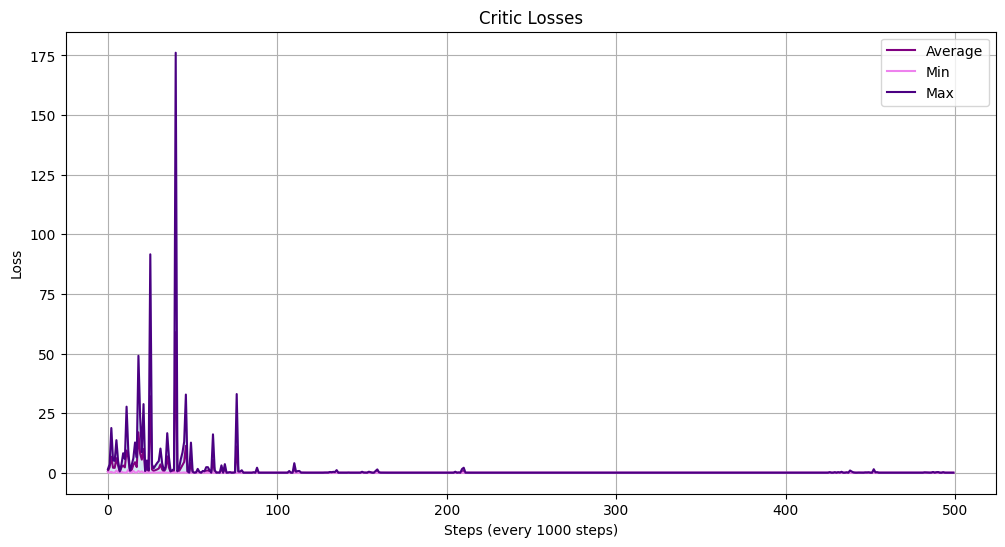

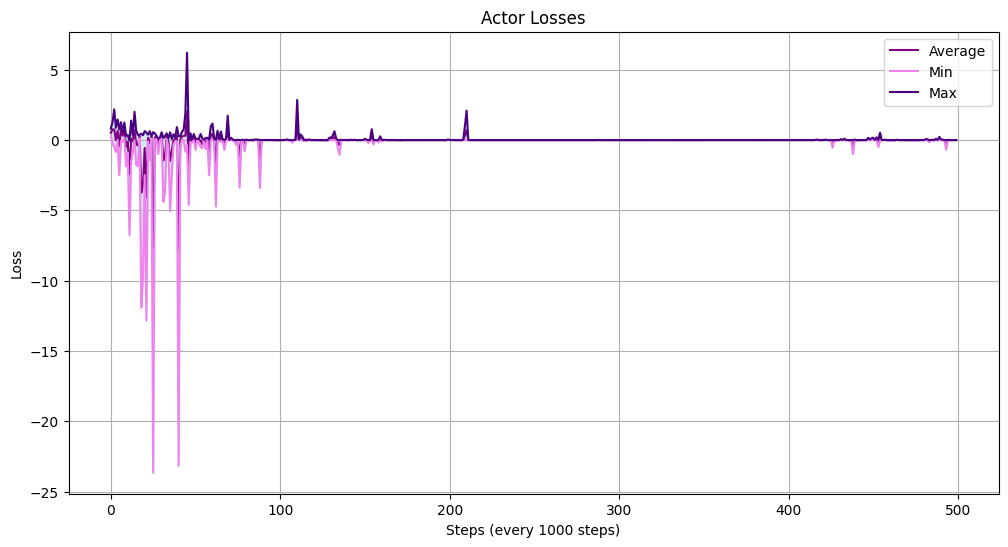

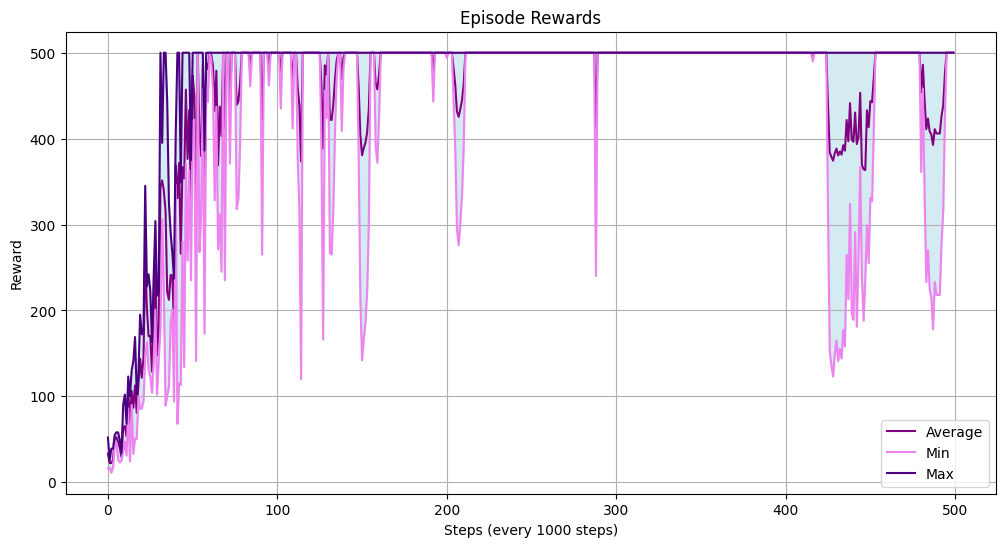

In [39]:
# Get stats for all_critic_losses
min_critic_losses, max_critic_losses, avg_critic_losses = get_stats(all_critic_losses)
min_actor_losses, max_actor_losses, avg_actor_losses = get_stats(all_actor_losses)
min_episode_rewards, max_episode_rewards, avg_episode_rewards = get_stats(all_episode_rewards)

# Plot stats for all_critic_losses
plot_stats(min_critic_losses, max_critic_losses, avg_critic_losses, title='Critic Losses',ylabel='Loss',xlabel='Steps (every 1000 steps)',save_plots=True, folder_name='agent1')
plot_stats(min_actor_losses, max_actor_losses, avg_actor_losses, title='Actor Losses',ylabel='Loss',xlabel='Steps (every 1000 steps)',save_plots=True, folder_name='agent1')
plot_stats(min_episode_rewards, max_episode_rewards, avg_episode_rewards, title='Episode Rewards',ylabel='Reward',xlabel='Steps (every 1000 steps)',save_plots=True, folder_name='agent1')

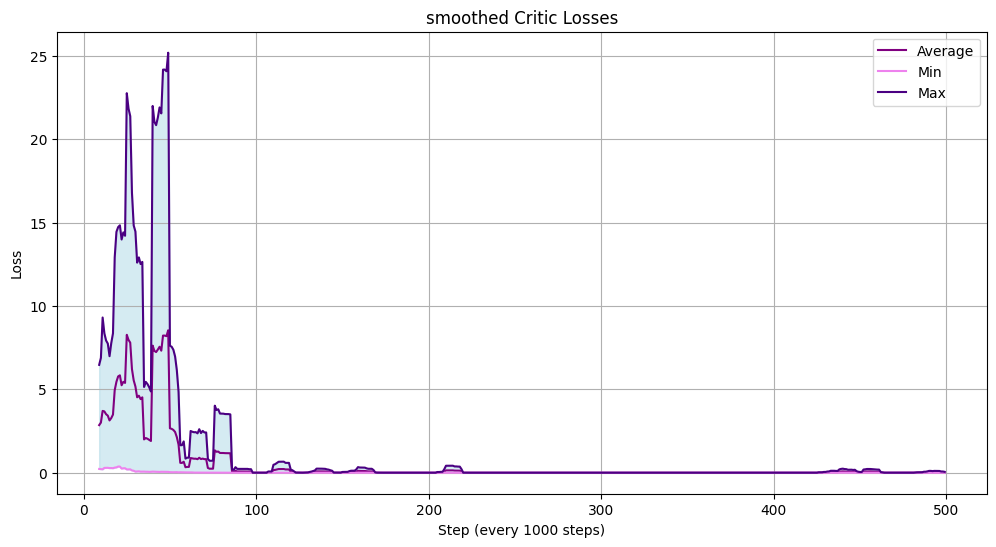

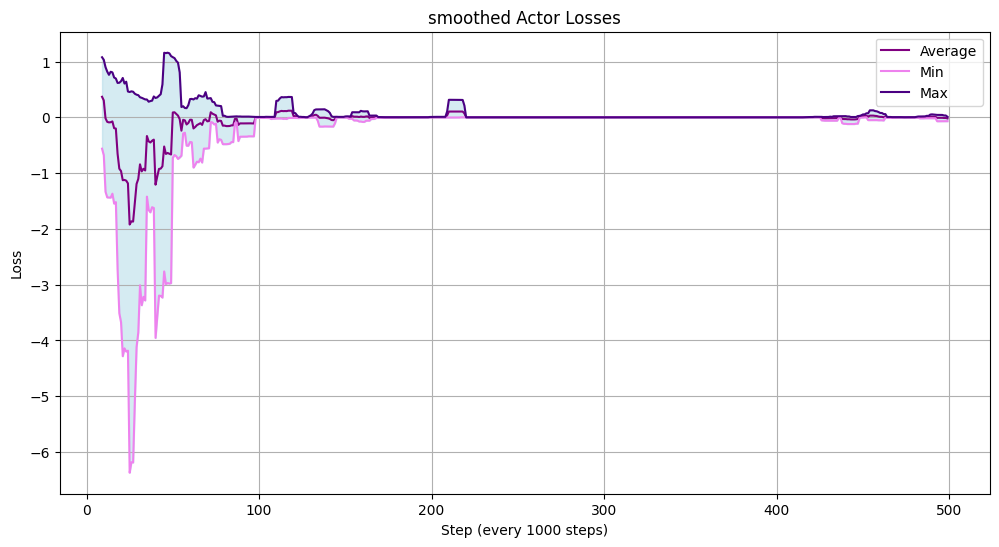

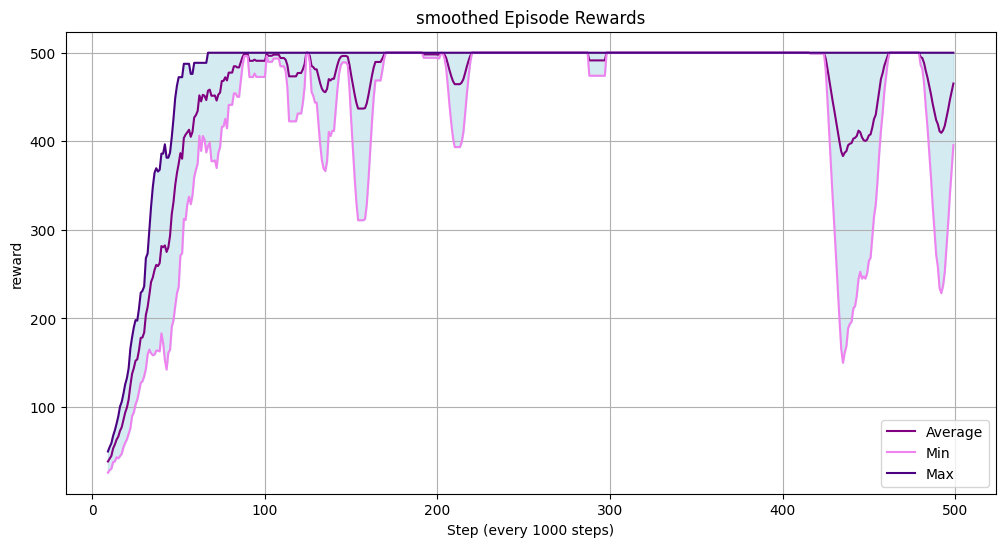

In [40]:
# Plot smoothed stats for all_critic_losses
plot_smoothed_stats(min_critic_losses, max_critic_losses, avg_critic_losses, window_size=10, title='smoothed Critic Losses', ylabel='Loss', xlabel='Step (every 1000 steps)',save_plots=True, folder_name='agent1')
plot_smoothed_stats(min_actor_losses, max_actor_losses, avg_actor_losses, window_size=10, title='smoothed Actor Losses', ylabel='Loss', xlabel='Step (every 1000 steps)',save_plots=True, folder_name='agent1')
plot_smoothed_stats(min_episode_rewards, max_episode_rewards, avg_episode_rewards, window_size=10, title='smoothed Episode Rewards', ylabel='reward', xlabel='Step (every 1000 steps)',save_plots=True, folder_name='agent1')

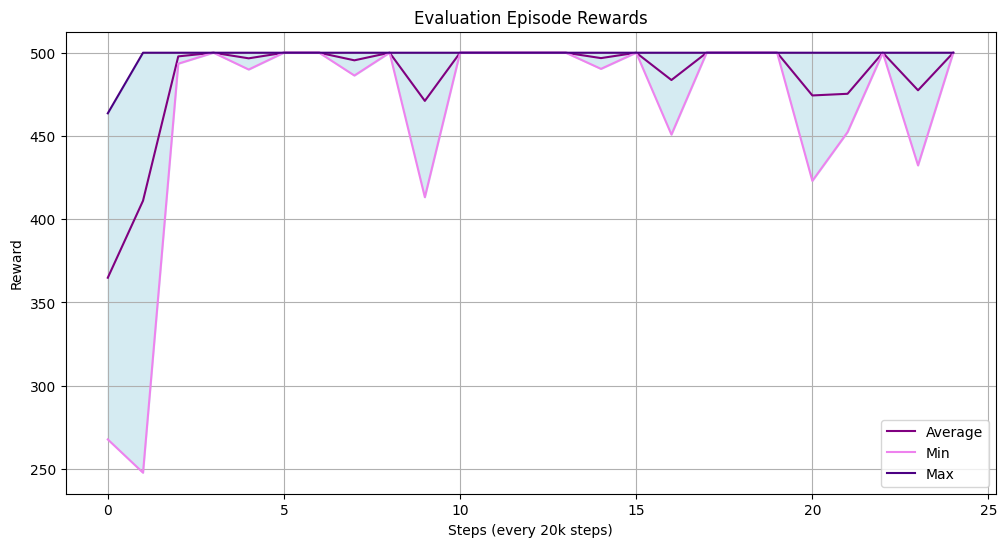

In [41]:
# Get stats for evaluation rewards
min_eval_rew, max_eval_rew, avg_eval_rew = get_stats(all_evaluation_reward_means)

# Plot stats for all_critic_losses
plot_stats(min_eval_rew, max_eval_rew, avg_eval_rew, title='Evaluation Episode Rewards',ylabel='Reward',xlabel='Steps (every 20k steps)',save_plots=True, folder_name='agent1')


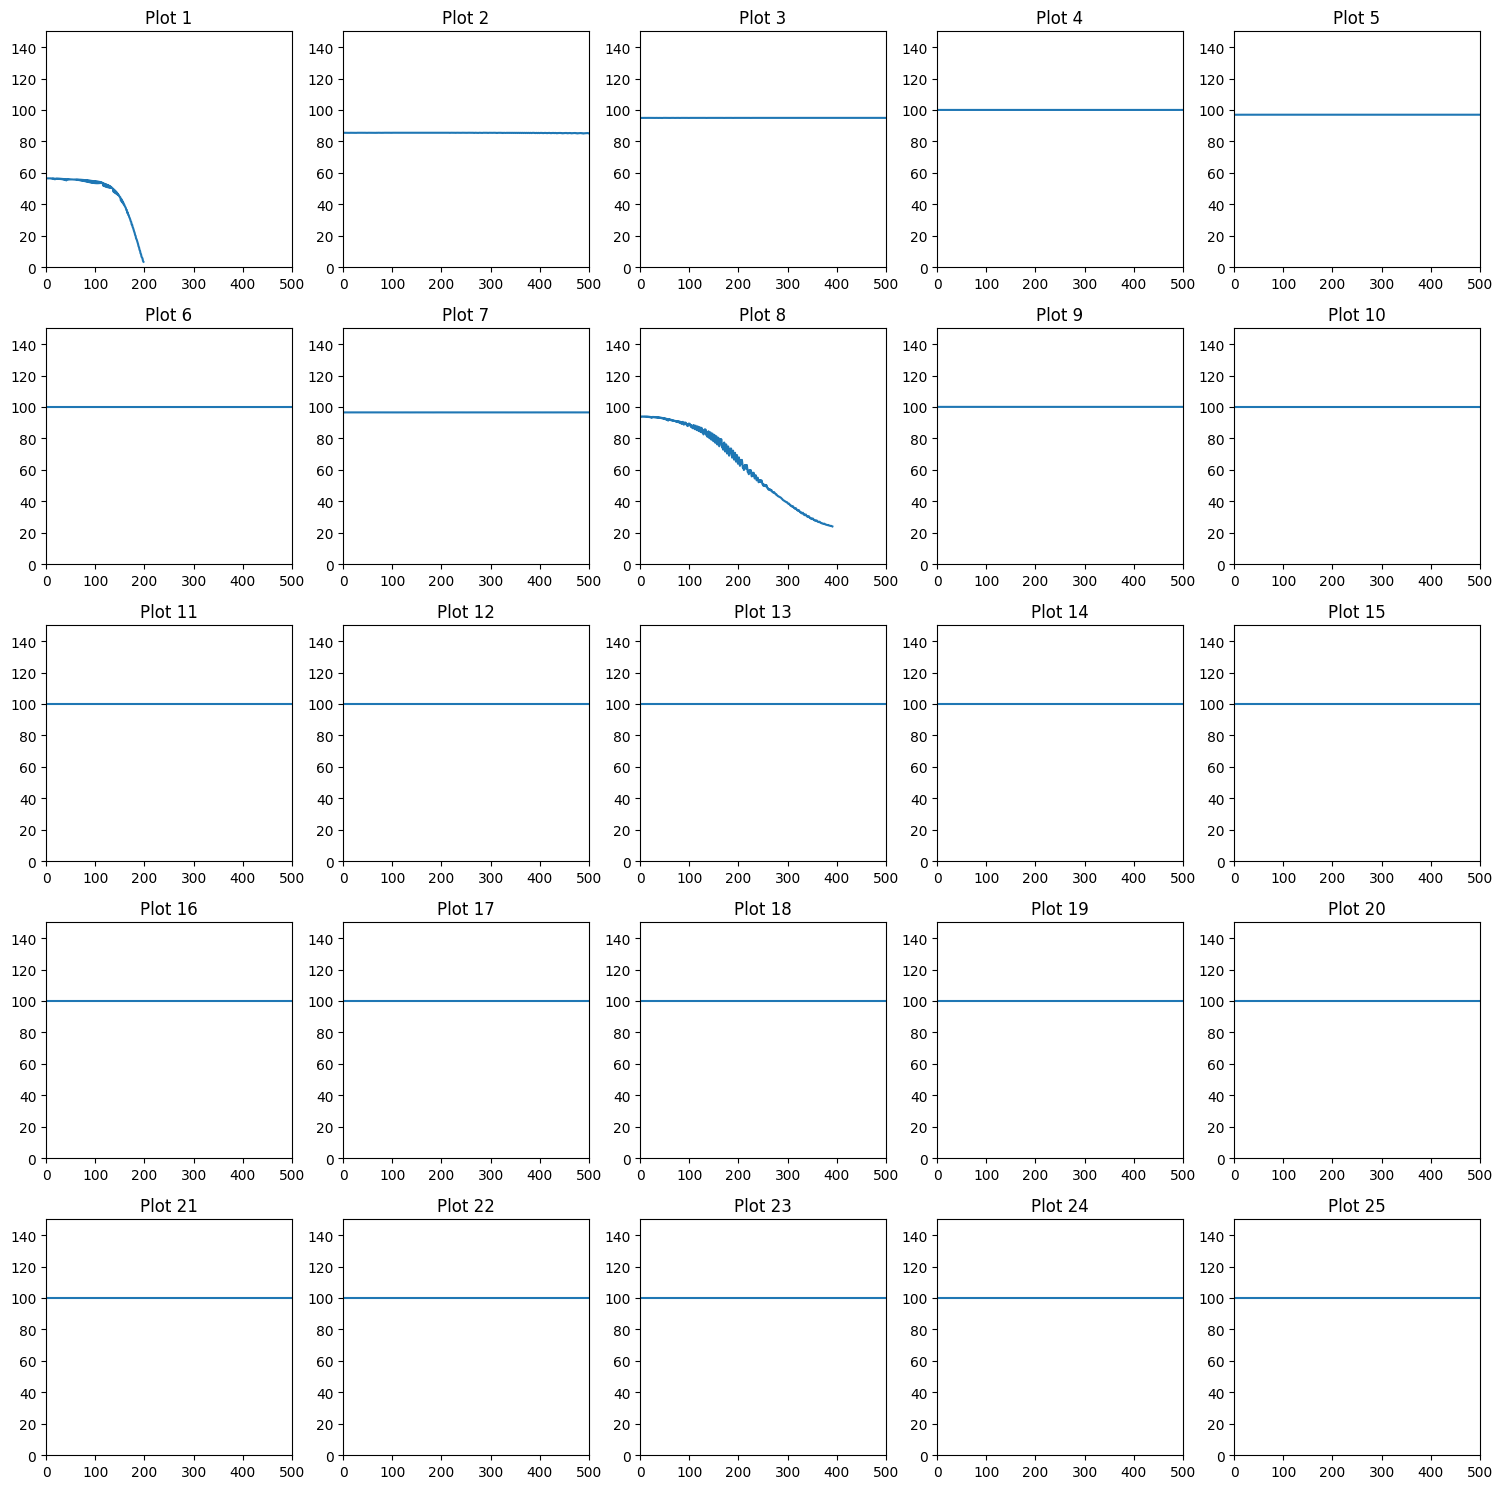

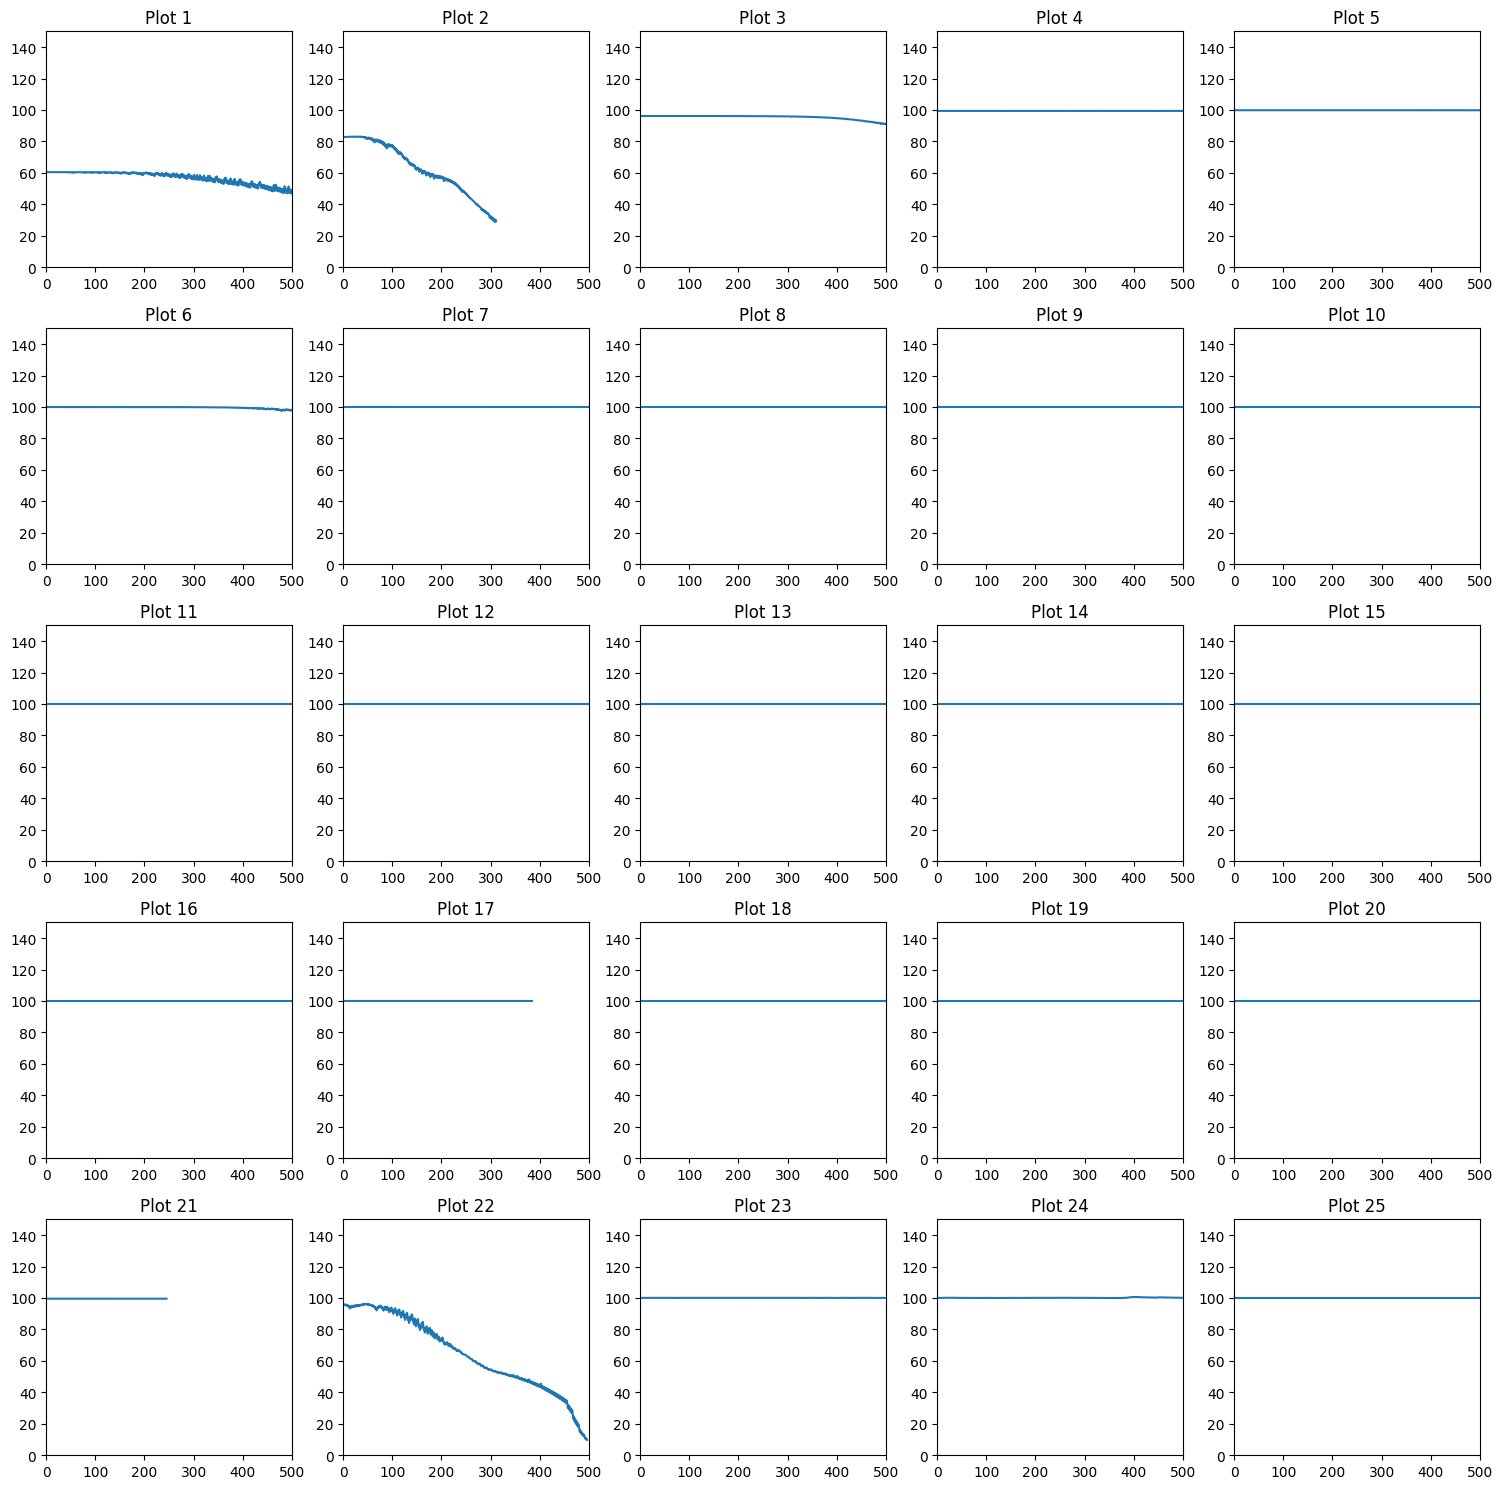

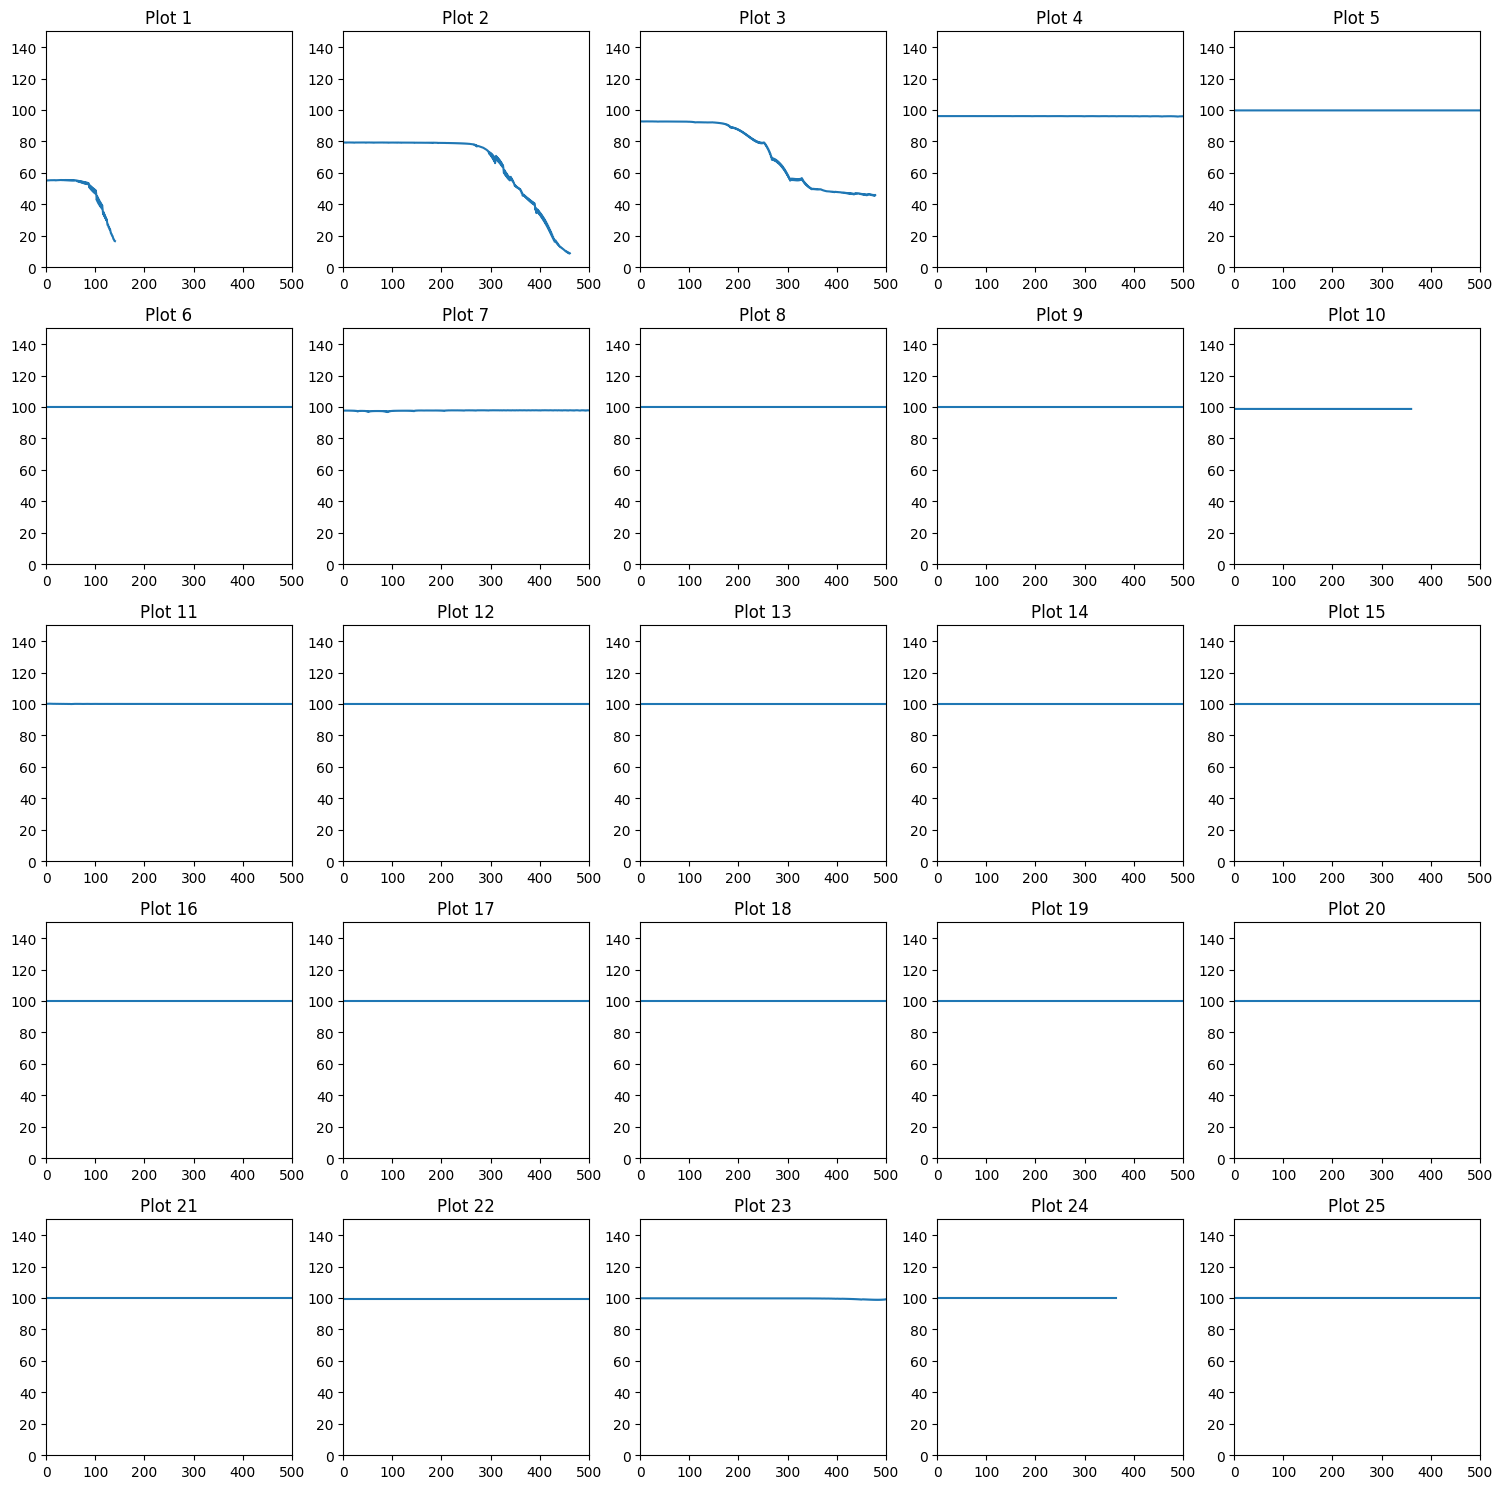

In [42]:
plot_and_save_trajectories(all_evaluation_value_trajectories, save_plots=True, folder_name='agent1', x_range=[0, 500], y_range=[0, 150])


### saving agents and data

In [25]:
# # Save all_* dictionaries
folder_name = "agent1_data"
os.makedirs(folder_name, exist_ok=True)

with open(folder_name+'/all_dicts.pkl', 'wb') as f:
    pickle.dump([all_critic_losses, all_actor_losses, all_episode_rewards, \
                 all_evaluation_reward_means, all_evaluation_reward_stds, all_evaluation_value_trajectories], f)

# Save agent1 dictionary
with open(folder_name+'/agent.pkl', 'wb') as f:
    pickle.dump(agent1, f)

# 3.2 Adding complexity: stochastic rewards
### vanilla A2C (fully-online)

In [27]:
device = "cpu"
print(device)

# hyperparameters
gamma_ = 0.99
lr_actor = 1e-5
lr_critic = 1e-3
total_steps_budget = 500000

# neural network structure
input_size = 4
hidden_size = 64
output_size_actor = 2
output_size_critic = 1

seeds = [893, 22, 53426]

agent1_stoch = {}
all_critic_losses_stoch = {}
all_actor_losses_stoch = {}
all_episode_rewards_stoch = {}
all_evaluation_reward_means_stoch = {}
all_evaluation_reward_stds_stoch = {}
all_evaluation_value_trajectories_stoch = {}


cpu


In [28]:
for i in range(3):
    
    set_seed(seeds[i])
    # Initialize environment, agent and optimizers
    env = gym.make('CartPole-v1')
    agent = Agent(input_size, hidden_size, \
                    output_size_actor, output_size_critic, \
                    gamma_, lr_actor, lr_critic, \
                    device=device)
    actor_optimizer = torch.optim.Adam(agent.actor.parameters(), lr_actor)
    critic_optimizer = torch.optim.Adam(agent.critic.parameters(), lr_critic)

    # Initialize recording lists
    all_critic_losses_stoch[i] = []
    all_actor_losses_stoch[i] = []
    all_episode_rewards_stoch[i] = []
    all_evaluation_reward_means_stoch[i] = []
    all_evaluation_reward_stds_stoch[i] = []
    all_evaluation_value_trajectories_stoch[i] = []

    critic_losses = []
    actor_losses = []
    episode_rewards = []


    # reset flags
    reached_train_budget = False
    episode = 0
    done = False

    # Training loop
    while not reached_train_budget:
        reset_seed = np.random.randint(0, 1000000) # Random seed for resetting the environment, fixed sequence because of set_seed() call above
        state, _ = env.reset(seed=reset_seed)
        state = tensor(state).to(device)  # Convert state to a tensor
        episode_reward = 0

        # Run an episode
        while not done:
            action = agent.select_action(state, mode="learning")
            next_state, reward, terminated, truncated, _ = env.step(action.detach().item())
            agent.num_steps += 1
            next_state = tensor(next_state).to(device)  # Convert next_state to a tensor
            done = terminated or truncated
            episode_reward += reward

            # apply stochastic mask on reward
            mask = 1
            if np.random.rand() < 0.9: mask = 0 # with probability 0.9 cancel out reward passed to learner
            reward_masked = reward * mask

            # Add the experience to the batch
            experience = (state, action, reward_masked, next_state, terminated)

            # Train the agent
            actor_loss, critic_loss = train(agent, actor_optimizer, critic_optimizer, experience)
            critic_losses.append(critic_loss)
            actor_losses.append(actor_loss)
            state = next_state

            # logging procedures
            if agent.num_steps % 20000 == 0: 
                print("---- Proceeding to evaluate model ... ----")
                mean_reward, std_reward, value_trajectories = agent.evaluate_agent(num_episodes=10)
                all_evaluation_reward_means_stoch[i].append(mean_reward)
                all_evaluation_reward_stds_stoch[i].append(std_reward)
                all_evaluation_value_trajectories_stoch[i].append(value_trajectories[0])
                print(f"Mean reward: {mean_reward:.2f}, Std reward: {std_reward:.2f}, total steps: {agent.num_steps}")
                print("----     Evaluation finished        ----")
            
            if agent.num_steps % 1000 == 0:
                all_episode_rewards_stoch[i].append(episode_rewards[-1])
                all_actor_losses_stoch[i].append(actor_losses[-1])
                all_critic_losses_stoch[i].append(critic_losses[-1])


            if (agent.num_steps >= total_steps_budget): 
                reached_train_budget = True
                break

        done = False
        episode += 1
        episode_rewards.append(episode_reward)
        if episode % 100 == 0:
            print(f"-------- Episode {episode} ended with reward {episode_reward} --------")
            print(f"Actor loss: {actor_losses[-1]:.4f}, Critic loss: {critic_losses[-1]:.4f}")
            print(f"Total steps taken during training: {agent.num_steps}")

    if reached_train_budget:
        print(f"Reached total training budget of {total_steps_budget} steps ----> Stopping training at episode {episode}")
    
    agent1_stoch[i] = agent # record the agent

env.close()


-------- Episode 100 ended with reward 20.0 --------
Actor loss: -0.9342, Critic loss: 1.3829
Total steps taken during training: 2283
-------- Episode 200 ended with reward 45.0 --------
Actor loss: 0.1749, Critic loss: 0.0337
Total steps taken during training: 5366
-------- Episode 300 ended with reward 22.0 --------
Actor loss: 0.1688, Critic loss: 0.0883
Total steps taken during training: 9469
-------- Episode 400 ended with reward 63.0 --------
Actor loss: -0.0029, Critic loss: 0.0037
Total steps taken during training: 14627
---- Proceeding to evaluate model ... ----
Mean reward: 61.90, Std reward: 21.65, total steps: 20000
----     Evaluation finished        ----
-------- Episode 500 ended with reward 54.0 --------
Actor loss: -1.3051, Critic loss: 0.7868
Total steps taken during training: 21025
-------- Episode 600 ended with reward 120.0 --------
Actor loss: -0.1669, Critic loss: 0.6558
Total steps taken during training: 27980
-------- Episode 700 ended with reward 140.0 -------

### saving agents and data

In [30]:
# # Save all_* dictionaries
folder_name = "agent1_data_stoch"
os.makedirs(folder_name, exist_ok=True)

with open(folder_name+'/all_dicts.pkl', 'wb') as f:
    pickle.dump([all_critic_losses_stoch, all_actor_losses_stoch, all_episode_rewards_stoch, \
                 all_evaluation_reward_means_stoch, all_evaluation_reward_stds_stoch, all_evaluation_value_trajectories_stoch], f)

# Save agent1 dictionary
with open(folder_name+'/agent.pkl', 'wb') as f:
    pickle.dump(agent1_stoch, f)

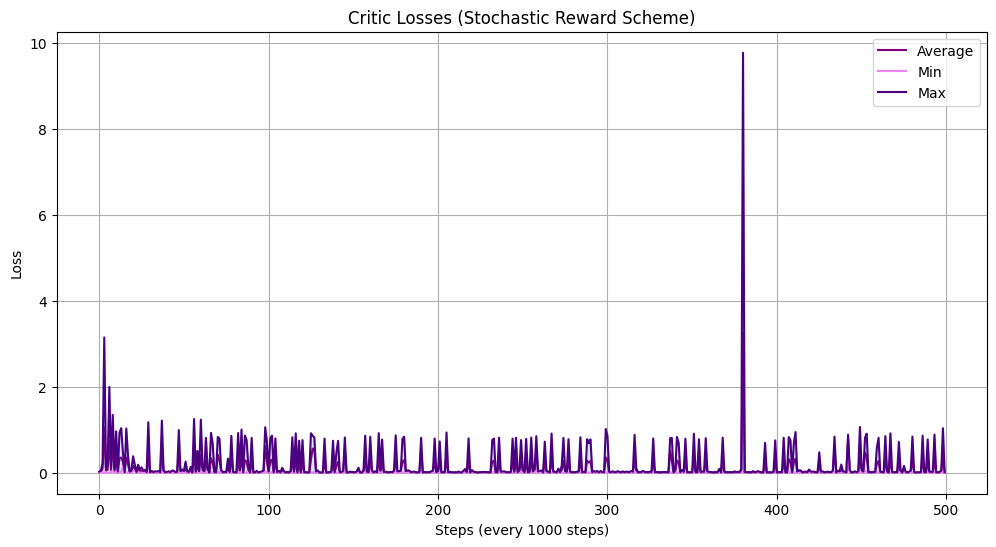

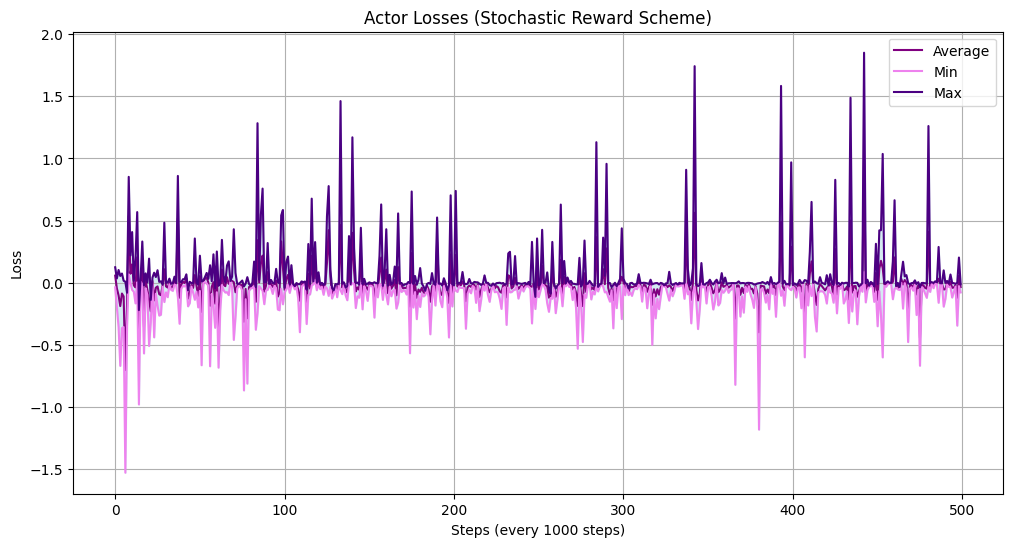

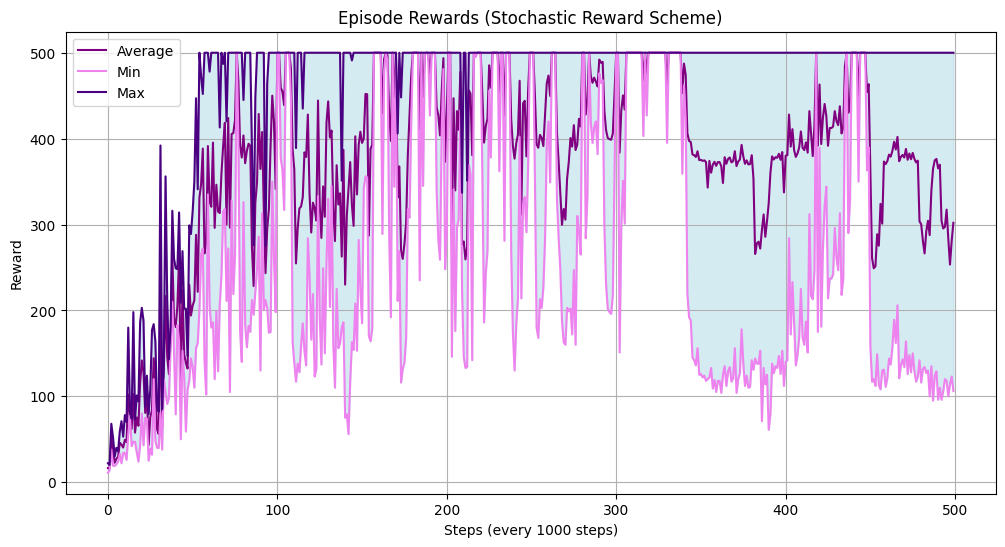

In [31]:
# Get stats
min_critic_losses, max_critic_losses, avg_critic_losses = get_stats(all_critic_losses_stoch)
min_actor_losses, max_actor_losses, avg_actor_losses = get_stats(all_actor_losses_stoch)
min_episode_rewards, max_episode_rewards, avg_episode_rewards = get_stats(all_episode_rewards_stoch)

# Plot stats 
plot_stats(min_critic_losses, max_critic_losses, avg_critic_losses, title='Critic Losses (Stochastic Reward Scheme)',ylabel='Loss',xlabel='Steps (every 1000 steps)',save_plots=True, folder_name='agent1_stoch')
plot_stats(min_actor_losses, max_actor_losses, avg_actor_losses, title='Actor Losses (Stochastic Reward Scheme)',ylabel='Loss',xlabel='Steps (every 1000 steps)',save_plots=True, folder_name='agent1_stoch')
plot_stats(min_episode_rewards, max_episode_rewards, avg_episode_rewards, title='Episode Rewards (Stochastic Reward Scheme)',ylabel='Reward',xlabel='Steps (every 1000 steps)',save_plots=True, folder_name='agent1_stoch')

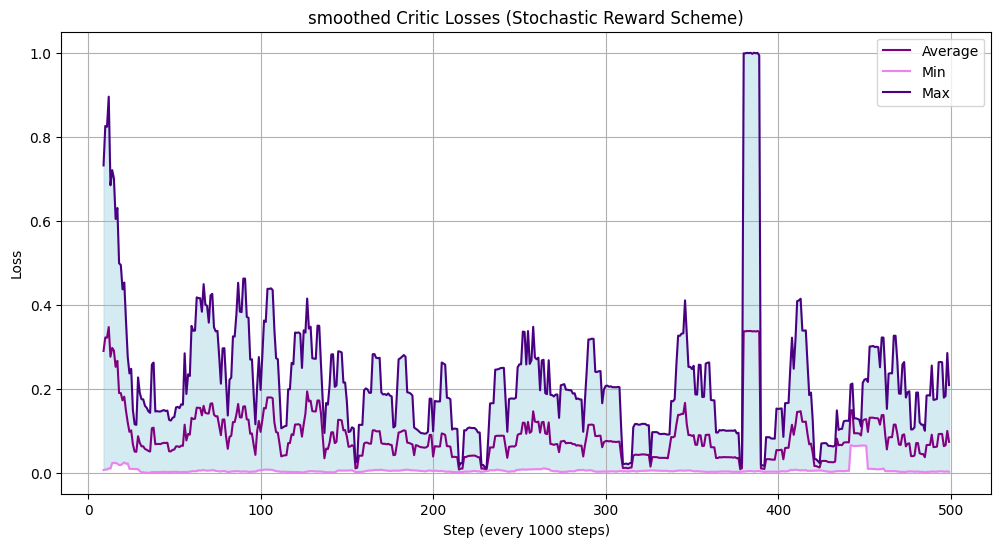

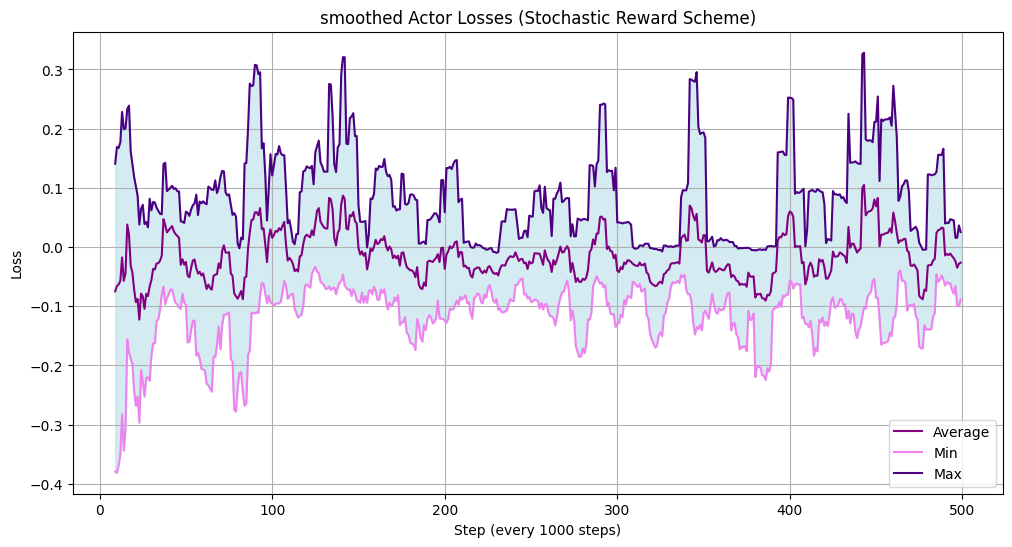

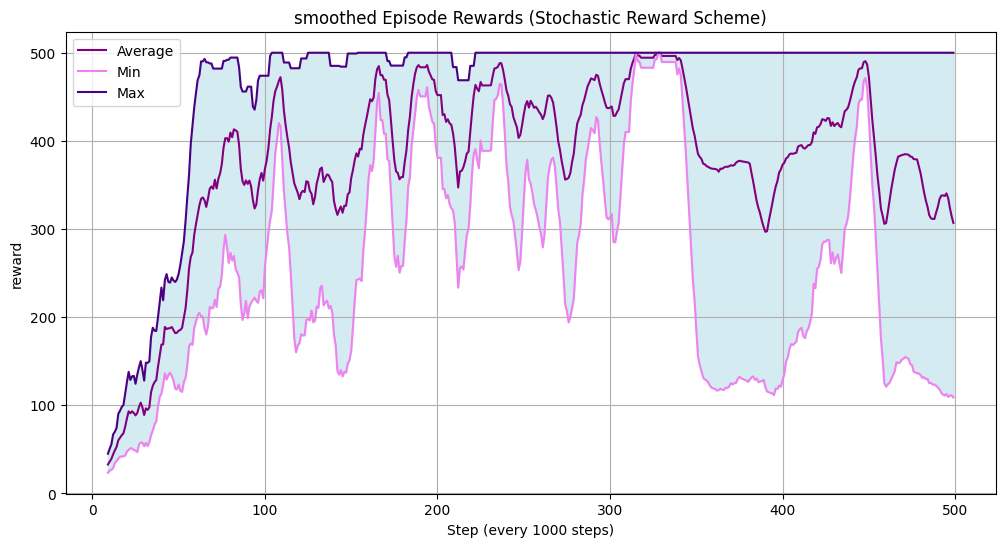

In [32]:
# Plot smoothed stats 
plot_smoothed_stats(min_critic_losses, max_critic_losses, avg_critic_losses, window_size=10, title='smoothed Critic Losses (Stochastic Reward Scheme)', ylabel='Loss', xlabel='Step (every 1000 steps)',save_plots=True, folder_name='agent1_stoch')
plot_smoothed_stats(min_actor_losses, max_actor_losses, avg_actor_losses, window_size=10, title='smoothed Actor Losses (Stochastic Reward Scheme)', ylabel='Loss', xlabel='Step (every 1000 steps)',save_plots=True, folder_name='agent1_stoch')
plot_smoothed_stats(min_episode_rewards, max_episode_rewards, avg_episode_rewards, window_size=10, title='smoothed Episode Rewards (Stochastic Reward Scheme)', ylabel='reward', xlabel='Step (every 1000 steps)',save_plots=True, folder_name='agent1_stoch')

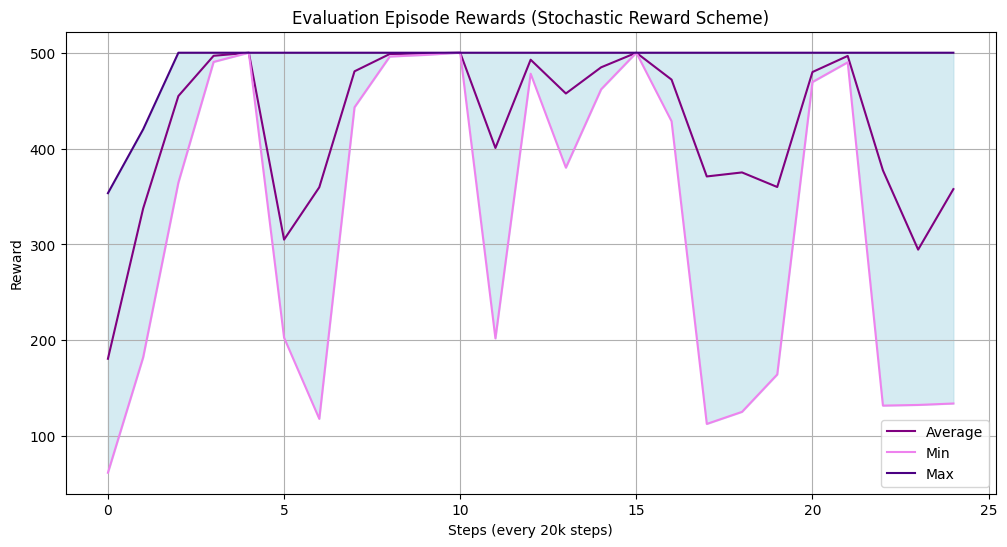

In [33]:
# Get stats for evaluation rewards
min_eval_rew, max_eval_rew, avg_eval_rew = get_stats(all_evaluation_reward_means_stoch)

# Plot stats for all_critic_losses
plot_stats(min_eval_rew, max_eval_rew, avg_eval_rew, title='Evaluation Episode Rewards (Stochastic Reward Scheme)',ylabel='Reward',xlabel='Steps (every 20k steps)',save_plots=True, folder_name='agent1_stoch')


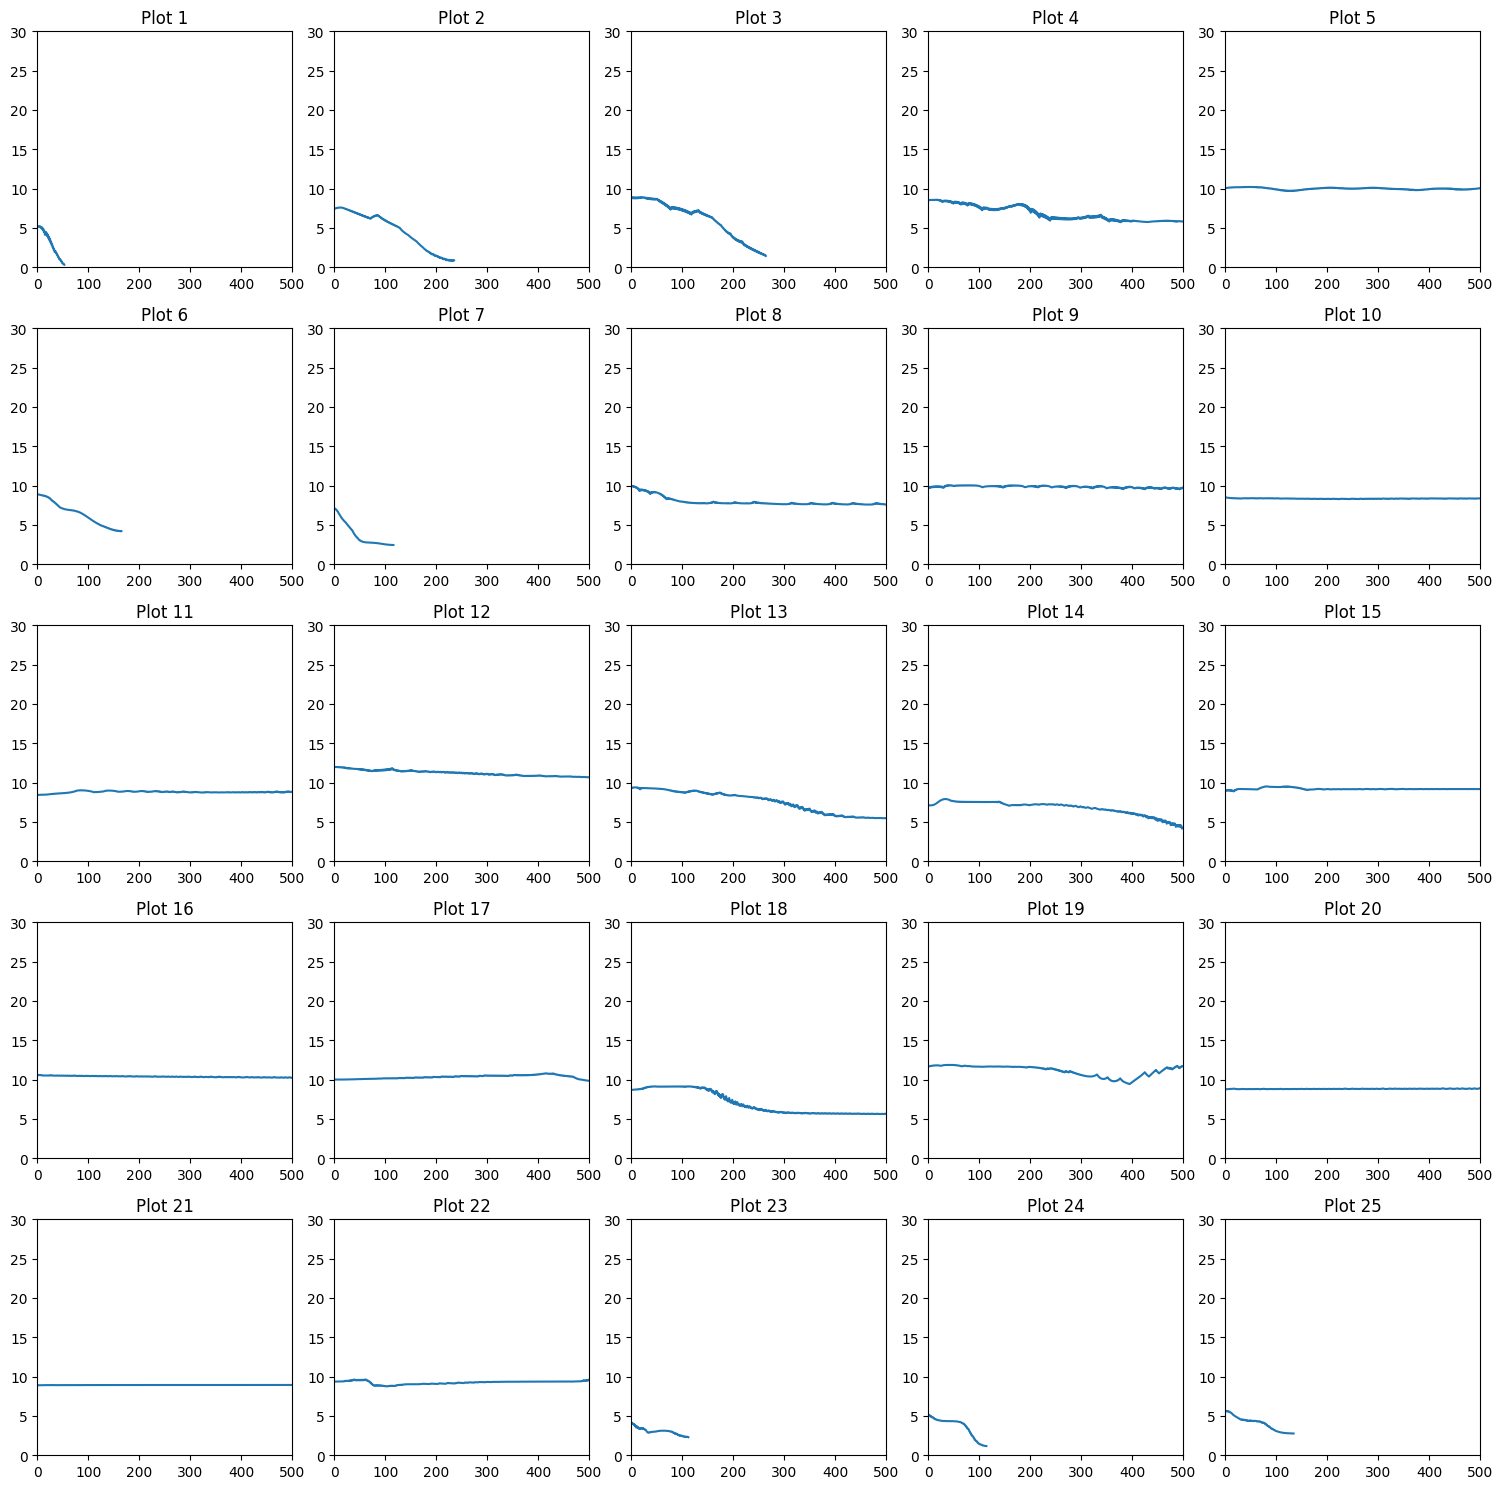

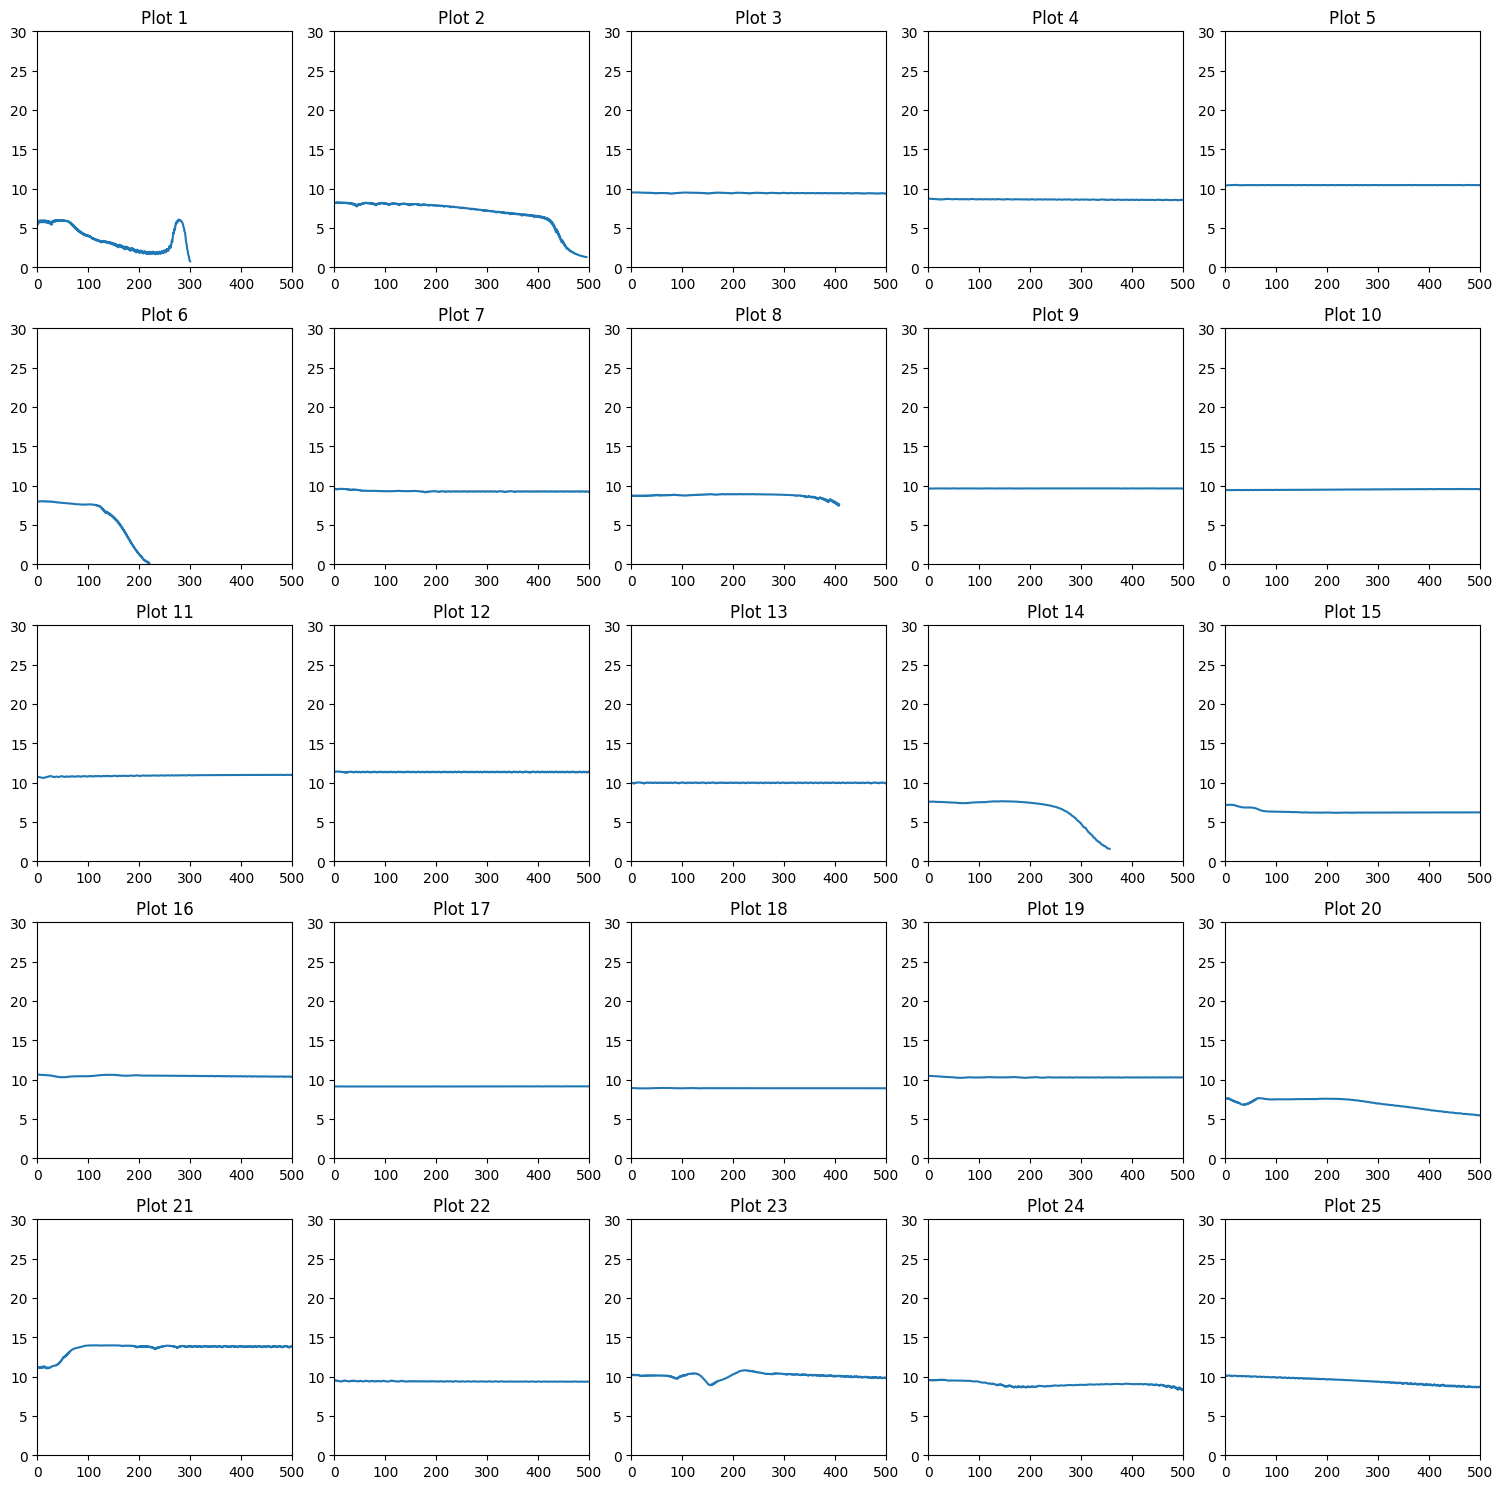

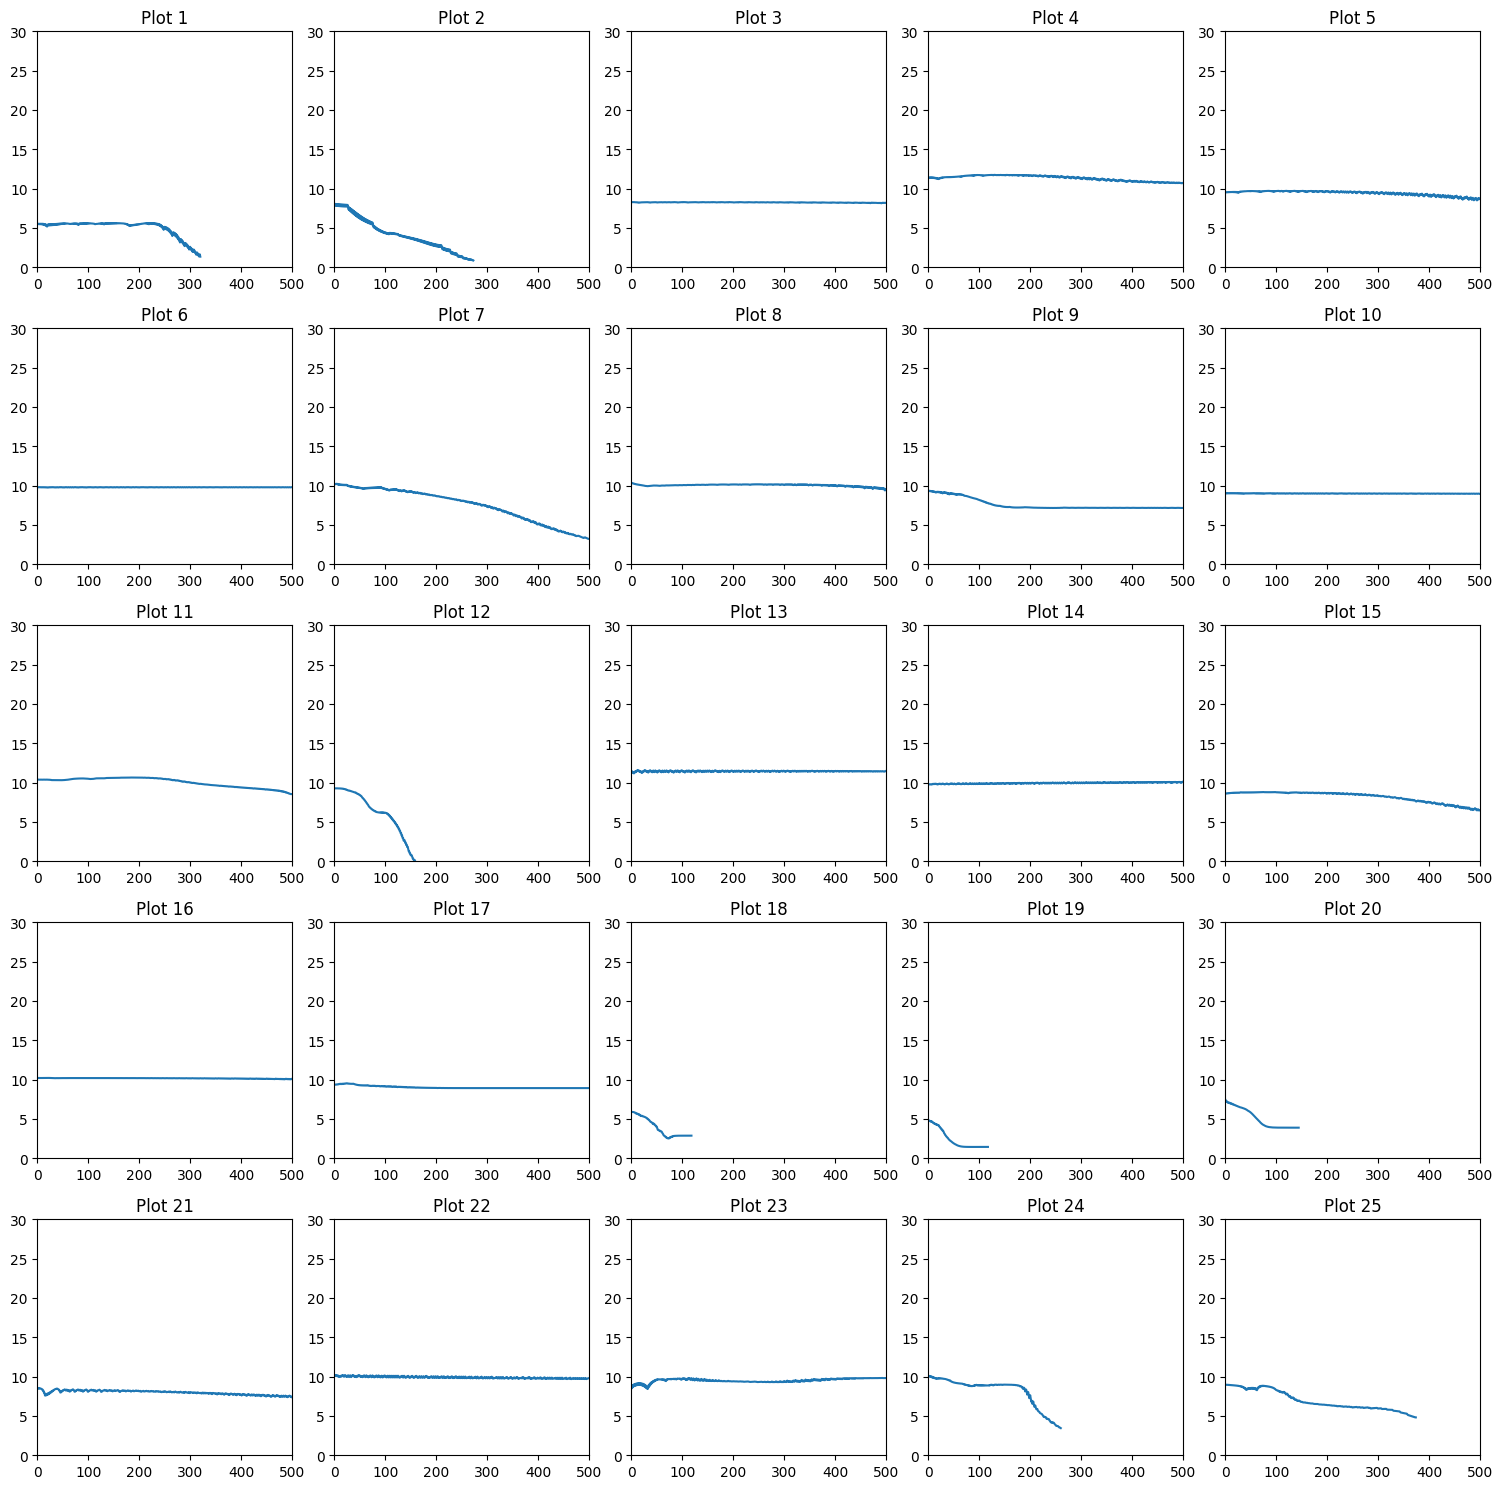

In [38]:
plot_and_save_trajectories(all_evaluation_value_trajectories_stoch, save_plots=True, folder_name='agent1_stoch', x_range=[0, 500], y_range=[0, 30])
